In [31]:

import os
import numpy as np
import pandas as pd
import scipy
from itertools import combinations
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from importlib import reload
import networkx as nx
import Levenshtein 
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from collections import Counter
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

# local imports
import file_loader_funcs as _load
import distance_funcs as _dist
import plotting_funcs as _plot

%matplotlib inline

In [2]:
""" Define a sample """

reload(_load)

SAMPLE_SIZE = 5000
ROOT_DIR = "/Volumes/Cooper_TB_Drive/research/rajapakse/b_cell_1/public-bcell-dataset/"
# DATASETS = [
#     'D1-M',
#     'D1-Na',
#     'D1-Nb',
#     'D2-N',
#     'D2-M',
#     'D3-M',
#     'D3-N',
# ]


DATASETS = [
    'D3-M',
    'D3-N',
]


data = {}

for dataset in DATASETS:
    DIRPATH = f"{ROOT_DIR}{dataset}"
    df = _load.get_samples(DIRPATH, n_sequences=SAMPLE_SIZE)
    data[dataset] = {'sample_df' : df}
    print(dataset, df.shape)

D3-M (5000, 75)
D3-N (5000, 75)


In [3]:
""" filter cdr3 region. NOTE: this is done by slicing the sequence
from the start of the v region `n` nucleotides based on the reported cdr3
length column """

def _apply_crd3_slice(row):
    """An apply function to extrasct the cdr3 region from the 
    sequence""" 
    seq = row['nucleotide']
    start = row['vIndex']
    end = start + row['cdr3Length']
    cdr3 = seq[start:end]
    return cdr3


# define the column in the sampled dataframe 
# for each sample
for k, v in data.items():
    v['sample_df']['cdr3_sequence'] = v['sample_df'].apply(lambda row: _apply_crd3_slice(row), axis=1)

In [4]:
"""Compute distance matrix using real minimal edit distance
from the python package leveshtien. """

for k, v in data.items():
    A = _dist.matrix_levenshtien(v['sample_df']['cdr3_sequence'].tolist())
    data[k]['distance_matrix'] = A
    print(k, A.shape)

D3-M (5000, 5000)
D3-N (5000, 5000)


In [5]:
""" Decompose and compute the optimal hard threshold """
reload(_dist)

# decompose all samples
for k, v in data.items():
    res = _dist.decompose_distances(data[k]['distance_matrix'])
    data[k]['decomposition'] = res
    print(k, data[k]['decomposition']['r'], data[k]['decomposition']['k'] )


D3-M 1.341886873600687 677
D3-N 1.201853501638123 695


In [6]:
""" try a few different clustering algorithms on X, the truncated left singular 
value matrix (non-square). 

NOTE: we choose the number of cluster to be the number of unqiue Gene Families 
identified in the sample

"""

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


for k, v in data.items():
    k_ind = v['decomposition']['k']
    X = v['decomposition']['u'][:, 0:k_ind]
    
    N_CLUSTERS = v['sample_df']['vFamilyName'].nunique()

    print(f"{k} N clusters: {N_CLUSTERS}")

    kmeans = KMeans(n_clusters=N_CLUSTERS).fit(X)
    algom = AgglomerativeClustering(n_clusters=N_CLUSTERS).fit(X)

    data[k]['clusters'] = {
        'KMeans' : kmeans,
        'AgglomerativeClustering' : algom,
    }

D3-M N clusters: 9
D3-N N clusters: 10


In [7]:
# """ plot some clusters using TNSE """

# KEYS = ['D3-N', 'D3-M']
# CLUSTER_TYPE = 'AgglomerativeClustering'

# matplotlib.rcParams['figure.dpi'] = 300
# fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# cmaps = ['viridis', 'plasma']

# for i, key in enumerate(KEYS):

#     A = data[key]['distance_matrix']
#     labels = data[key]['clusters'][CLUSTER_TYPE].labels_

#     # reduce dimension to plot
#     X_embedded = TSNE(n_components=2).fit_transform(A)

#     axs[i].scatter(X_embedded[:, 0], 
#                    X_embedded[:, 1], 
#                    c=labels, 
#                    edgecolor='Gray',
#                    cmap=cmaps[i])
#     axs[i].set_title(key)
#     axs[i].set_xlabel("TSNE-1")
#     axs[i].set_ylabel("TSNE-2")


# plt.suptitle(f"{CLUSTER_TYPE} Clusters for {', '.join(KEYS)}", fontsize=20)
# outpath = f"figures/{CLUSTER_TYPE}_clusters{''.join(KEYS).replace('-', '')}.png"
# plt.savefig(outpath, bbox_inches='tight')    


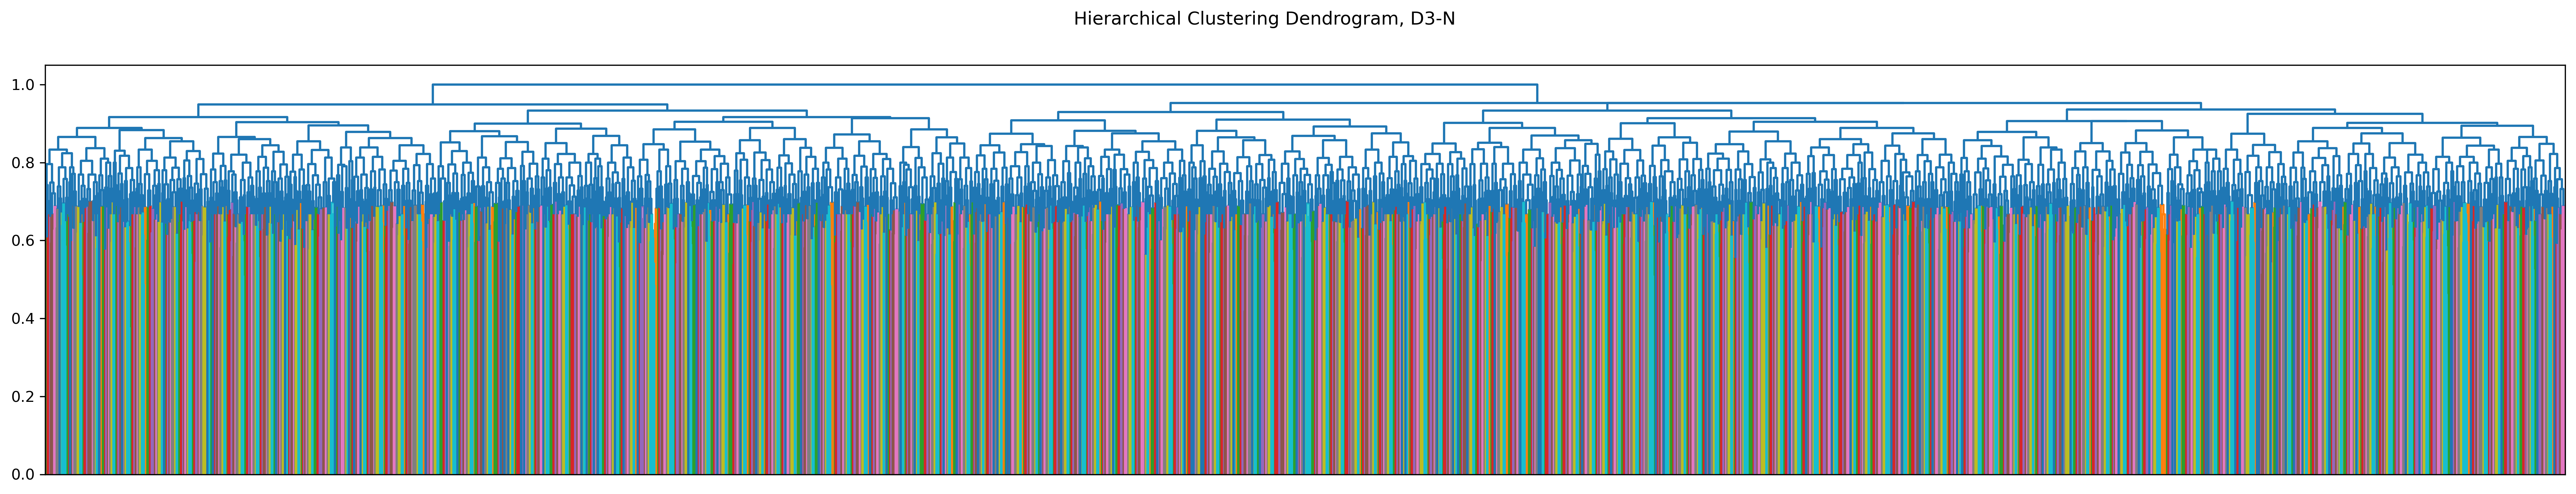

In [19]:
""" make a dendogram """

DEPTH= 15

reload(_plot)

for k, v in data.items():
    # k_ind = v['decomposition']['k']
    # X = v['decomposition']['u'][:, 0:k_ind]

    X = v['distance_matrix']
    model = AgglomerativeClustering(affinity='precomputed', linkage='complete', distance_threshold=0, n_clusters=None).fit(X)

    matplotlib.rcParams['figure.dpi'] = 300
    matplotlib.rcParams['figure.figsize'] = (30,5)

    plt.cla()

    # _plot.plot_dendrogram(model, truncate_mode='level', orientation='top', p=DEPTH, no_labels=True)
    _plot.plot_dendrogram(model, distance_sort='True', no_labels=True)

    plt.suptitle(f'Hierarchical Clustering Dendrogram, {k}')
    # plt.xlabel('Cluster size)')
    # plt.ylabel('Distance')


    outpath = f"figures/dendogram_{k.replace('-', '')}.png"
    plt.savefig(outpath, bbox_inches='tight')  




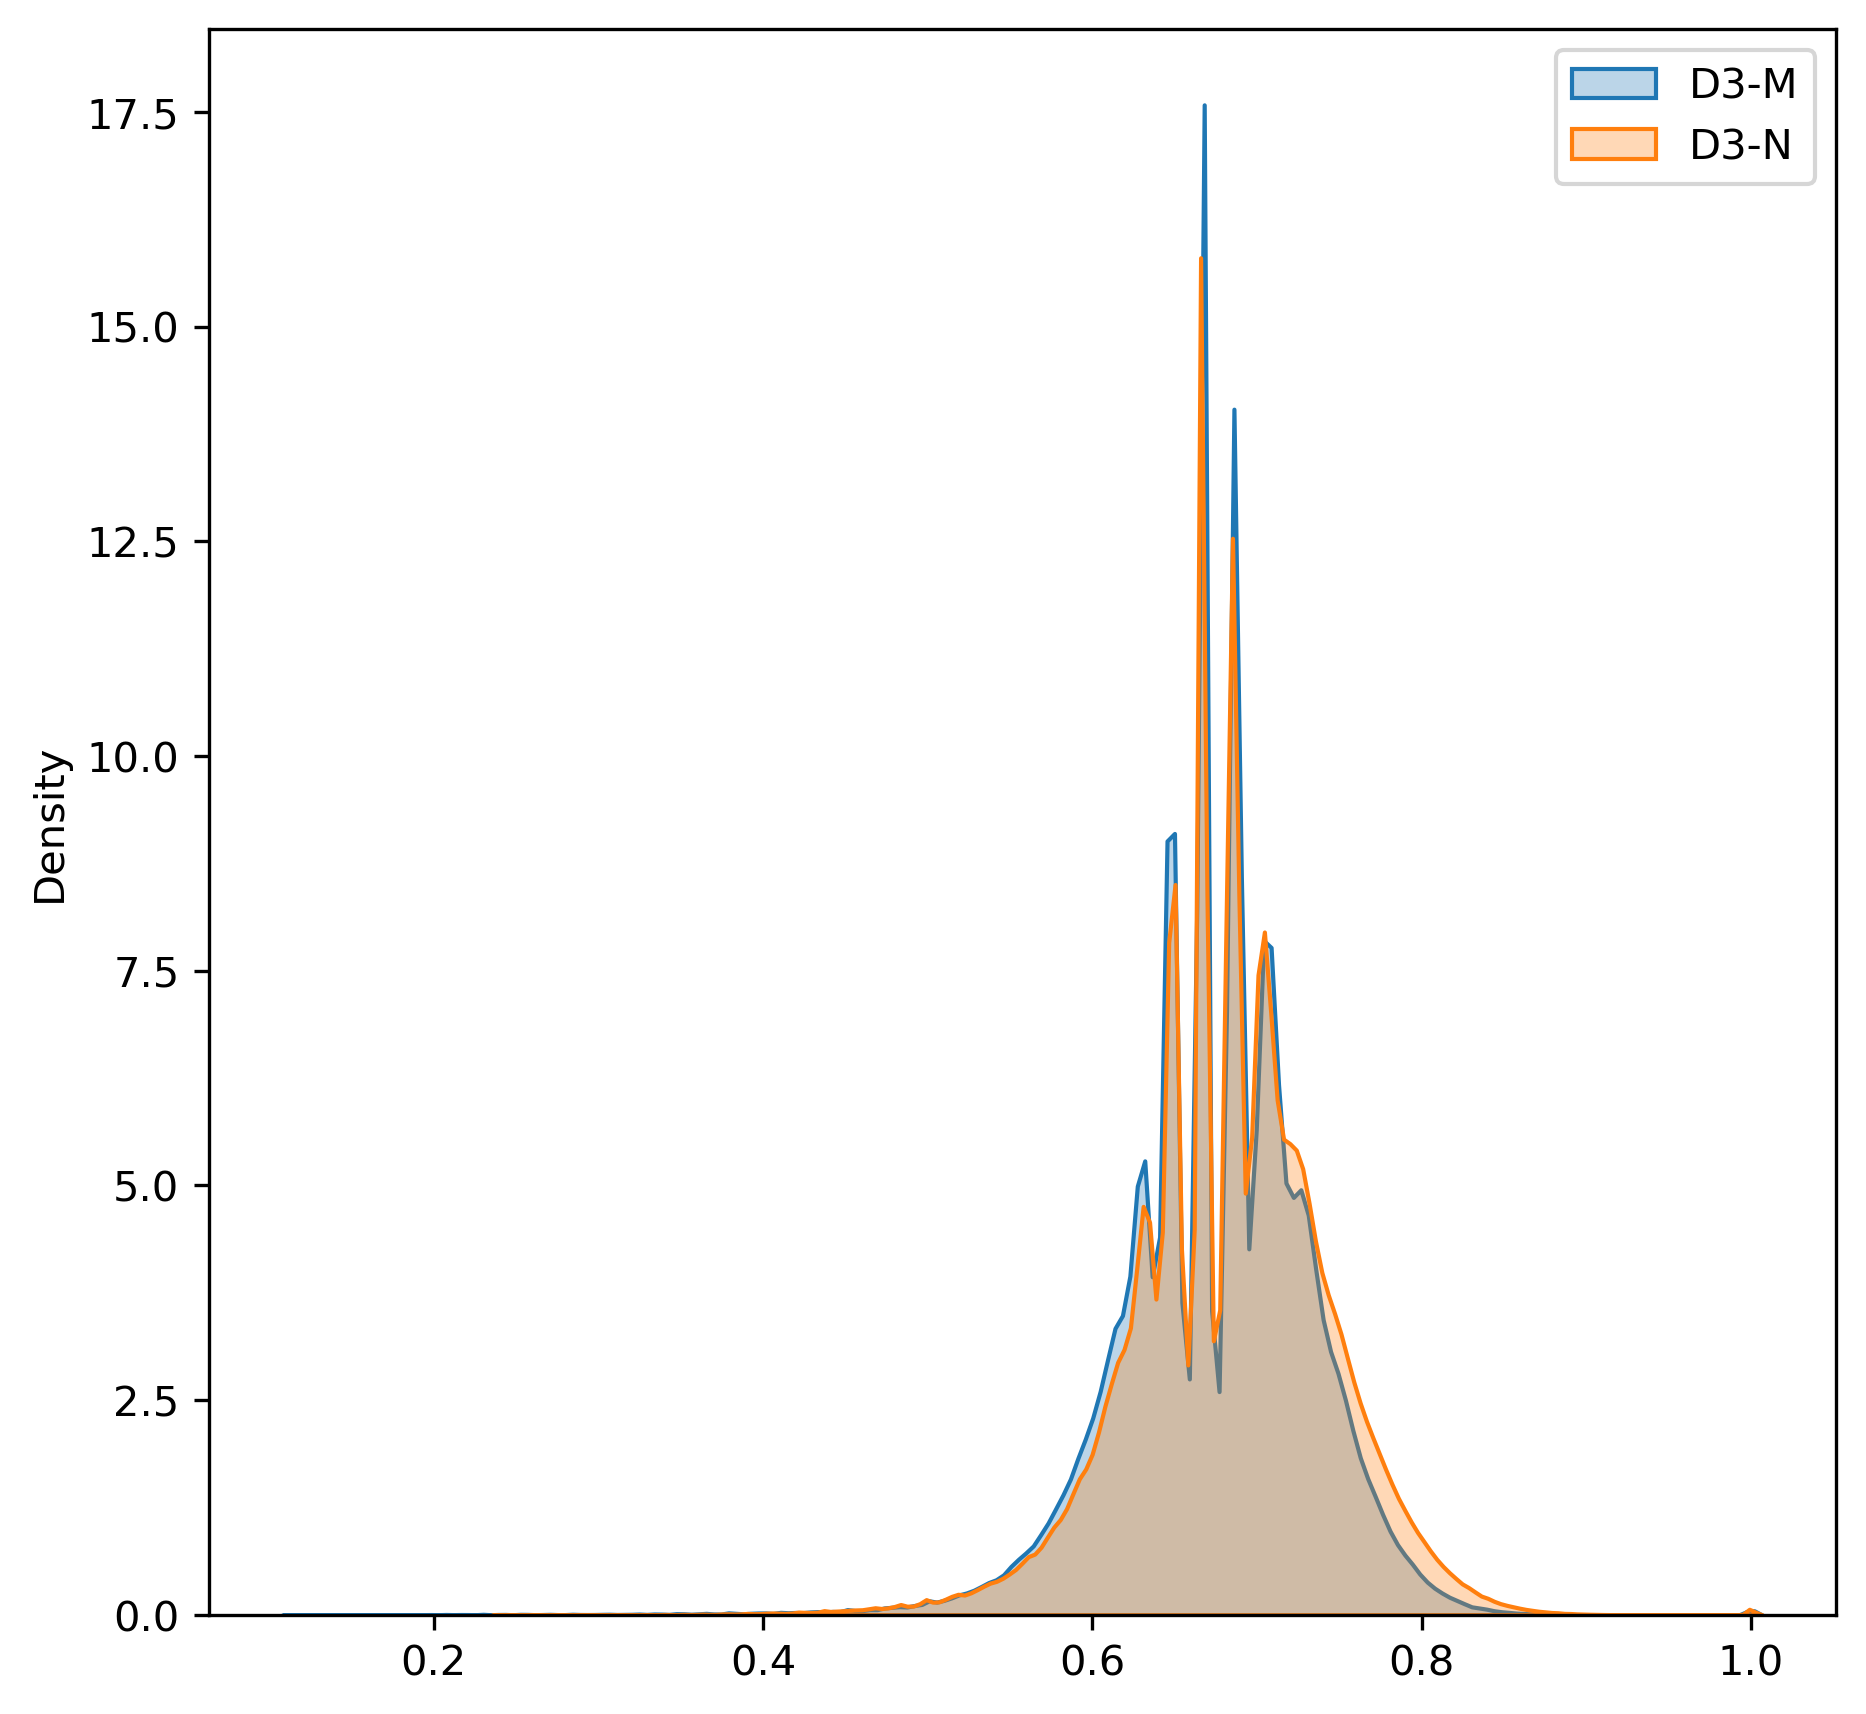

In [28]:
"""
distribution of distances
"""
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (7, 7)

count = -1
for k, v in data.items():

    count += 1
    
    upper = np.triu(v['distance_matrix'])
    dist = [i for i in upper.ravel() if not i == 0.0]


    sns.kdeplot(dist, shade=True, alpha=0.3, color=f"C{count}", label=f"{k}")

plt.legend()


D3-M N clusters: 100
D3-N N clusters: 100


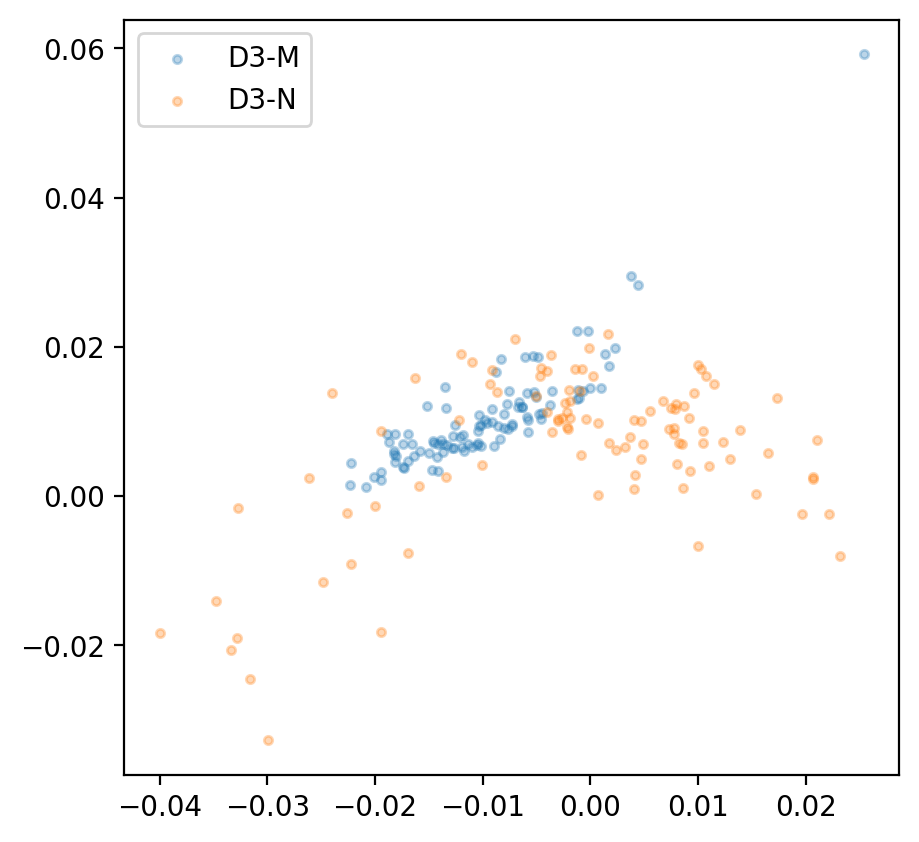

In [43]:
""" KMeans cluster centroids by k """

# K_RANGE = [int(i) for i in np.linspace(10, 110, 10)]
K_RANGE = [100]

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (5,5)

count = -1
for k, v in data.items():
    count += 1
    k_ind = v['decomposition']['k']
    X = v['decomposition']['u'][:, 0:k_ind]

    for i, N_CLUSTERS in enumerate(K_RANGE):
        print(f"{k} N clusters: {N_CLUSTERS}")
        kmeans = KMeans(n_clusters=N_CLUSTERS).fit(X)

        centers = np.array(kmeans.cluster_centers_)

        if i == 0:
            plt.scatter(centers[:,0], centers[:,1], 
                        color=f"C{count}", alpha=0.3, 
                        label=f"{k}", marker=".")

        else:
            plt.scatter(centers[:,0], centers[:,1], 
                        color=f"C{count}", alpha=0.3, marker=".")

    plt.legend()
    # plt.suptitle(f"{k} KMeans Cluster Distributions")
    # plt.xlabel("Cluster ID")
    # plt.ylabel("Proportion  of Cells")











In [12]:
# """ plot data by gene family """

# KEYS = ['D1-Na', 'D1-M']

# matplotlib.rcParams['figure.dpi'] = 300
# fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# for i, key in enumerate(KEYS):

#     A = data[key]['distance_matrix']

#     # reduce dimension to plot
#     X_embedded = TSNE(n_components=2).fit_transform(A)

#     axs[i].scatter(X_embedded[:, 0], 
#                    X_embedded[:, 1], 
#                    c=data[key]['sample_df']['vFamilyName'].astype('category').cat.codes, 
#                    edgecolor='Gray')
#     axs[i].set_title(key)


# plt.suptitle(f"{', '.join(KEYS)} by Gene Family", fontsize=20)
# outpath = f"figures/{''.join(KEYS).replace('-', '')}_by_gene_family.png"
# plt.savefig(outpath, bbox_inches='tight')    